# Dog Breed Identification - Kaggle competition

## Init

* Load the training set.
* View a couple of images.
* Create a one layer model.
* Get a place on the leaderboard.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import time
import random
import fnmatch
from shutil import copyfile, rmtree
import csv
import math

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Input, Dense, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.applications import vgg16
from keras.applications import inception_v3
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import xception
from tqdm import tqdm


%matplotlib inline

Using TensorFlow backend.


In [3]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    """Taken from Fast.ai utils."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
def get_steps(gen):
    """
    Generally define an epoch as an entire pass through the dataset.
    
    Therefore, we say that steps per epoch = num samples / batch size.
    """
    return gen.samples / gen.batch_size


def generate_submission(predictions, gen, output_file='sub.csv'):  
    fh = open(output_file, 'w')
    writer = csv.writer(fh)
    writer.writerow(['id'] + [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])])
    for filename, prediction in zip(gen.filenames, predictions):
        dog_id = filename.split('/')[-1].split('.')[0]
        writer.writerow([dog_id] + ['{0:f}'.format(p) for p in prediction])
    fh.close()

### Prepare training set

In [3]:
labels = pd.read_csv('data/labels.csv')

In [4]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,4e2e5e75b04fd4603d9a59af546c59b2,scottish_deerhound
freq,1,126


Thinking a 90/10 training/dev split = 900 in the dev set.

Time to get it into a format that Keras likes.

In [5]:
if not os.path.exists('./data/prepared'):
    
    random.seed(42)

    for label in labels.breed.unique():
        os.makedirs(f'./data/prepared/train/{label}', exist_ok=True)
        os.makedirs(f'./data/prepared/dev/{label}', exist_ok=True)

    for _, item_id, label in labels.itertuples():
        is_dev = random.random() > 0.8

        which_set = 'dev' if is_dev else 'train'
        copyfile(
            f'./data/train/{item_id}.jpg',
            f'./data/prepared/{which_set}/{label}/{item_id}.jpg')

In [29]:
_gen = ImageDataGenerator().flow_from_directory('./data/prepared/train', batch_size=4, class_mode='sparse')
x_batch, y_batch = next(_gen)

Found 9162 images belonging to 120 classes.


In [30]:
label_to_id = {id: label for label, id in _gen.class_indices.items()}

In [31]:
titles = [label_to_id[i] for i in y_batch]

In [32]:
def get_columns():
    return [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])]


def get_ids():
    return [f.split('/')[-1].split('.')[0] for f in test_gen.filenames]


def submit_predictions(preds, path='./submissions/out.csv'):
    df = pd.DataFrame(columns=get_columns(), data=preds)
    df.insert(0, 'id', get_ids())
    df.to_csv(path, float_format='%.19f', index=False)


def plot_random(predictions, filenames, num_images=4):
    perms = np.random.permutation(len(predictions))
    filenames = np.asarray(filenames)
    # Take a look at a few predictions from the test generator
    imgs = []
    labels = []
    for label, filename in zip(predictions[perms][:num_images], filenames[perms][:num_images]):
        labels.append(label_to_id[np.argmax(label)])
        imgs.append(img_to_array(load_img('./data/test/' + filename, target_size=(256, 256))))
    imgs = np.asarray(imgs)
    plots(imgs, titles=labels)

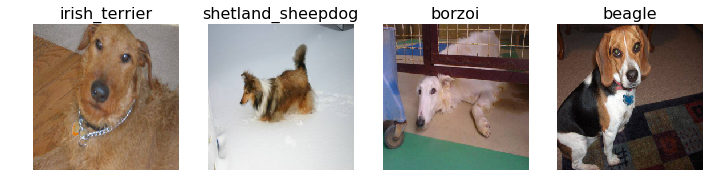

In [7]:
plots(x_batch, titles=titles)

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
train_gen = train_datagen.flow_from_directory('./data/prepared/train')
dev_gen = train_datagen.flow_from_directory('./data/prepared/dev')
sample_gen = train_datagen.flow_from_directory('./data/prepared/sample')

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.
Found 1534 images belonging to 120 classes.


In [69]:
test_datagen = ImageDataGenerator(rescale=1./255)

## Create baseline model

In [15]:
print("Image size:", x_batch.shape)

Image size: (4, 256, 256, 3)


In [16]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=get_steps(sample_gen), validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/2
48/47 [==============================] - 17s - loss: 15.6187 - acc: 0.0137 - val_loss: 15.9204 - val_acc: 0.0123
Epoch 2/2
48/47 [==============================] - 11s - loss: 15.9282 - acc: 0.0104 - val_loss: 15.8973 - val_acc: 0.0123


Random accuracy would be around 0.0083 (120/1), so it's twice as good as random. Not great though. Doesn't appear to be getting any better either.

Few predict examples:

In [19]:
labels = []
for img_id in np.argmax(model.predict_generator(train_gen, 10), 1)[:10]:
    labels.append(label_to_id[img_id])
    
print(labels)

['irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'bouvier_des_flandres', 'irish_wolfhound', 'irish_wolfhound', 'tibetan_terrier', 'irish_wolfhound']


Seems to be predicting a lot of the same thing. Maybe try lowering the learning rate?

In [ ]:
# model = load_model('./checkpoints/simple_nn.h5')

In [20]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit_generator(
    train_gen, epochs=2, steps_per_epoch=get_steps(sample_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))                                                                                                            

Epoch 1/2
48/47 [==============================] - 58s - loss: 5.5171 - acc: 0.0195 - val_loss: 9.2812 - val_acc: 0.0179
Epoch 2/2
48/47 [==============================] - 57s - loss: 5.3836 - acc: 0.0273 - val_loss: 6.5603 - val_acc: 0.0198


Seems to be doing a little better. Will see how far that gets me on the full set.

In [22]:
model.fit_generator(
    train_gen, epochs=4, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))                                                                                                            

Epoch 1/4
287/286 [==============================] - 237s - loss: 4.8112 - acc: 0.0773 - val_loss: 5.3584 - val_acc: 0.0302
Epoch 2/4
287/286 [==============================] - 237s - loss: 3.7571 - acc: 0.1993 - val_loss: 5.3418 - val_acc: 0.0321
Epoch 3/4
287/286 [==============================] - 237s - loss: 2.9419 - acc: 0.3497 - val_loss: 5.5681 - val_acc: 0.0340
Epoch 4/4
287/286 [==============================] - 239s - loss: 2.3495 - acc: 0.4758 - val_loss: 5.6207 - val_acc: 0.0292


In [24]:
test_gen = gen.flow_from_directory('./data/test', batch_size=64, class_mode=None, shuffle=False)

Found 10357 images belonging to 1 classes.


In [33]:
# To do: rerun this with checkpointed model.
predictions = model.predict_generator(test_gen, steps=math.ceil(test_gen.samples // 64))

KeyboardInterrupt: 

In [ ]:
generate_submission(predictions, test_gen, './submissions/simple_nn.csv')

That puts me at position 112, 3 away from the very bottom.

In [34]:
model.save('./checkpoints/simple_nn.h5')

### L2 regularisation

In [44]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax', kernel_regularizer=l2(0.01))])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 331s - loss: 2.8140 - acc: 0.9167 - val_loss: 7.6600 - val_acc: 0.1749
Epoch 2/2
1539/1539 [==============================] - 328s - loss: 1.9881 - acc: 0.9967 - val_loss: 7.9553 - val_acc: 0.1738


Helped with overfitting a tiny bit but hasn't added much to the performance. Let's see what val accuracy we can get with the whole set.

In [46]:
train_gen = gen.flow_from_directory('./data/prepared/train')

Found 9190 images belonging to 120 classes.


In [51]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
9190/9190 [==============================] - 1336s - loss: 1.1190 - acc: 0.9763 - val_loss: 7.5201 - val_acc: 0.0668
Epoch 2/2
9190/9190 [==============================] - 1332s - loss: 0.5899 - acc: 0.9775 - val_loss: 7.1179 - val_acc: 0.0505


Much better. VGG16 next.

Loss is coming down but accuracy sucks. Sup with that?

In [52]:
predictions = model.predict_generator(test_gen, steps=test_gen.samples)

In [53]:
generate_submission(predictions, test_gen, 'sub_l2.csv')

## VGG16

### Retrain last layer

Going to load VGG16 from Keras and retrain just the fully-connected layers starting from the first layer.

In [41]:
train_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, horizontal_flip=True)
dev_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', target_size=(224, 224))
dev_gen = dev_datagen.flow_from_directory('./data/prepared/dev', target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [42]:
vgg16_conv = VGG16(weights='imagenet', include_top=True)

In [43]:
vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [44]:
for layer in vgg16_conv.layers:
    layer.trainable = False

In [45]:
x = Dense(120, activation='softmax', name='predictions')(vgg16_conv.layers[-2].output)

model = Model(inputs=vgg16_conv.input, outputs=x)
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [47]:
checkpoint = ModelCheckpoint('./checkpoints/vgg_v1_first_layer.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [48]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 164s 571ms/step - loss: 1.8539 - acc: 0.6059 - val_loss: 1.7399 - val_acc: 0.6547
Epoch 2/10
287/286 [==============================] - 169s 589ms/step - loss: 0.6466 - acc: 0.8300 - val_loss: 1.6838 - val_acc: 0.6802
Epoch 3/10
287/286 [==============================] - 164s 571ms/step - loss: 0.3716 - acc: 0.8917 - val_loss: 1.7459 - val_acc: 0.6726
Epoch 4/10
287/286 [==============================] - 170s 591ms/step - loss: 0.2180 - acc: 0.9340 - val_loss: 1.6682 - val_acc: 0.6915
Epoch 5/10
287/286 [==============================] - 164s 573ms/step - loss: 0.1316 - acc: 0.9584 - val_loss: 1.7460 - val_acc: 0.6868
Epoch 6/10
287/286 [==============================] - 164s 573ms/step - loss: 0.1150 - acc: 0.9632 - val_loss: 1.8265 - val_acc: 0.6887
Epoch 7/10
286/286 [============================>.] - ETA: 0s - loss: 0.1259 - acc: 0.9649
Epoch 00007: reducing learning rate to 0.00010000000474974513.
287/286 [=====================

### Retrain all FC layers

In [62]:
for layer in model.layers[-3:]:
    layer.trainable = True

In [63]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
checkpoint = ModelCheckpoint('./checkpoints/vgg_v2_all_fc.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [65]:
model.load_weights('./checkpoints/vgg_v1_first_layer.h5')

In [66]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 202s 703ms/step - loss: 1.2276 - acc: 0.6764 - val_loss: 1.5872 - val_acc: 0.5981
Epoch 2/10
287/286 [==============================] - 201s 701ms/step - loss: 0.5782 - acc: 0.8407 - val_loss: 1.8273 - val_acc: 0.6094
Epoch 3/10
287/286 [==============================] - 202s 702ms/step - loss: 0.3970 - acc: 0.8880 - val_loss: 1.9607 - val_acc: 0.6104
Epoch 4/10
286/286 [============================>.] - ETA: 0s - loss: 0.3361 - acc: 0.9087
Epoch 00004: reducing learning rate to 9.999999747378752e-06.
287/286 [==============================] - 202s 703ms/step - loss: 0.3368 - acc: 0.9086 - val_loss: 2.0583 - val_acc: 0.6028


### Data Augmentation

Need to come up with a way to stop overfitting. Will try data aug first.

In [94]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

Found 9162 images belonging to 120 classes.


In [95]:
img = load_img('./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
dog_gen = train_datagen.flow(x, batch_size=1)

In [96]:
aug_dogs = []
for count, d in enumerate(dog_gen):
    aug_dogs.append(d)
    if count > 10:
        break

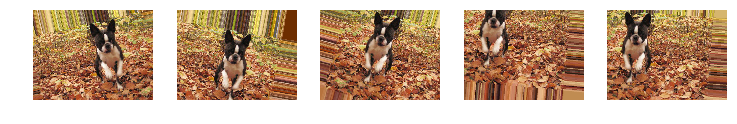

In [115]:
plots(np.concatenate(aug_dogs)[:5], figsize=(15,12))

In [116]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function=vgg16.preprocess_input)
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=32, target_size=(224, 224))

Found 9162 images belonging to 120 classes.


In [117]:
checkpoint = ModelCheckpoint('./checkpoints/vgg_v3_all_fc.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [118]:
model.load_weights('./checkpoints/vgg_v2_all_fc.h5')

In [119]:
K.set_value(model.optimizer.lr, 0.0001)

In [120]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 200s 698ms/step - loss: 1.5364 - acc: 0.5904 - val_loss: 1.5481 - val_acc: 0.6075
Epoch 2/10
287/286 [==============================] - 218s 758ms/step - loss: 1.1753 - acc: 0.6728 - val_loss: 1.4782 - val_acc: 0.6330
Epoch 3/10
287/286 [==============================] - 217s 756ms/step - loss: 0.9476 - acc: 0.7226 - val_loss: 1.4702 - val_acc: 0.6594
Epoch 4/10
287/286 [==============================] - 201s 702ms/step - loss: 0.8015 - acc: 0.7598 - val_loss: 1.5992 - val_acc: 0.6443
Epoch 5/10
287/286 [==============================] - 201s 702ms/step - loss: 0.7285 - acc: 0.7827 - val_loss: 1.5638 - val_acc: 0.6415
Epoch 6/10
286/286 [============================>.] - ETA: 0s - loss: 0.6548 - acc: 0.8024
Epoch 00006: reducing learning rate to 9.999999747378752e-06.
287/286 [==============================] - 201s 702ms/step - loss: 0.6548 - acc: 0.8023 - val_loss: 1.6363 - val_acc: 0.6632


In [121]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 199s 694ms/step - loss: 0.3749 - acc: 0.8829 - val_loss: 1.5244 - val_acc: 0.6698
Epoch 2/10
287/286 [==============================] - 217s 758ms/step - loss: 0.2828 - acc: 0.9111 - val_loss: 1.4672 - val_acc: 0.6943
Epoch 3/10
287/286 [==============================] - 201s 699ms/step - loss: 0.2424 - acc: 0.9254 - val_loss: 1.5252 - val_acc: 0.6849
Epoch 4/10
287/286 [==============================] - 202s 702ms/step - loss: 0.2305 - acc: 0.9267 - val_loss: 1.5293 - val_acc: 0.6887
Epoch 5/10
286/286 [============================>.] - ETA: 0s - loss: 0.1918 - acc: 0.9385
Epoch 00005: reducing learning rate to 9.999999747378752e-07.
287/286 [==============================] - 201s 702ms/step - loss: 0.1913 - acc: 0.9387 - val_loss: 1.5353 - val_acc: 0.6991


In [122]:
model.save('./models/vgg_aug_v1.h5')

In [126]:
test_gen = dev_datagen.flow_from_directory('./data/test', batch_size=32, class_mode=None, target_size=(224, 224), shuffle=False)

tic = time.time()
test_predictions = model.predict_generator(test_gen, steps=test_gen.samples // 32 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Found 10357 images belonging to 1 classes.
Took 166.34 seconds


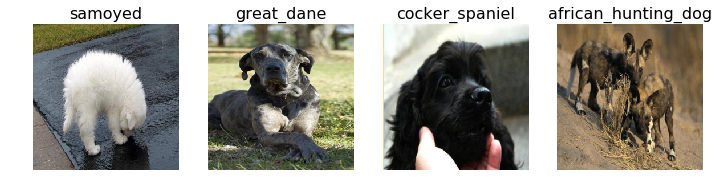

In [127]:
plot_random(test_predictions, test_gen.filenames)

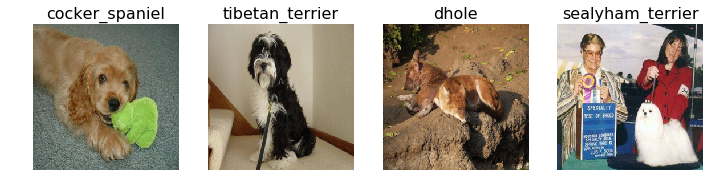

In [128]:
plot_random(test_predictions, test_gen.filenames)

Results seem to be quite reasonable but not enough to get into the top 50.

## VGG19

Going to use the same data augmentation used for VGG16. I'll also train the last dense layer then work my way up the FC layers.

In [8]:
from keras.applications import vgg19

In [9]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function=vgg19.preprocess_input,
    fill_mode='nearest')
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=32, target_size=(224, 224))

test_datagen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [10]:
vgg19_conv = vgg19.VGG19(weights='imagenet')  # Trying smaller image sizes

for layer in vgg19_conv.layers:
    layer.trainable = False
    
x = Dense(120, activation='softmax', name='predictions')(vgg19_conv.layers[-2].output)

model = Model(inputs=vgg19_conv.inputs, outputs=x)
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

In [136]:
checkpoint = ModelCheckpoint('./checkpoints/vgg19_v1_dense_training.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [137]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 199s 694ms/step - loss: 2.0125 - acc: 0.5030 - val_loss: 1.2004 - val_acc: 0.6519
Epoch 2/10
287/286 [==============================] - 205s 715ms/step - loss: 1.1075 - acc: 0.6769 - val_loss: 1.0344 - val_acc: 0.6858
Epoch 3/10
287/286 [==============================] - 200s 697ms/step - loss: 0.9440 - acc: 0.7206 - val_loss: 1.0772 - val_acc: 0.6764
Epoch 4/10
287/286 [==============================] - 206s 717ms/step - loss: 0.8272 - acc: 0.7488 - val_loss: 0.9506 - val_acc: 0.7038
Epoch 5/10
287/286 [==============================] - 200s 697ms/step - loss: 0.7541 - acc: 0.7700 - val_loss: 0.9832 - val_acc: 0.7132
Epoch 6/10
287/286 [==============================] - 200s 698ms/step - loss: 0.6754 - acc: 0.7927 - val_loss: 1.0194 - val_acc: 0.6811
Epoch 7/10
286/286 [============================>.] - ETA: 0s - loss: 0.6369 - acc: 0.7963
Epoch 00007: reducing learning rate to 0.0009999999776482583.
287/286 [======================

In [11]:
for layer in model.layers[-3:]:
    layer.trainable = True

In [12]:
model.compile(
    loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])

In [13]:
model.load_weights('./checkpoints/vgg19_v1_dense_training.h5')

In [14]:
checkpoint = ModelCheckpoint('./checkpoints/vgg19_v2_fc_training.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=4)

In [15]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 220s 766ms/step - loss: 1.3062 - acc: 0.6327 - val_loss: 1.2671 - val_acc: 0.6443
Epoch 2/10
287/286 [==============================] - 214s 747ms/step - loss: 0.9356 - acc: 0.7247 - val_loss: 1.2860 - val_acc: 0.6764
Epoch 3/10
287/286 [==============================] - 226s 786ms/step - loss: 0.6990 - acc: 0.7849 - val_loss: 1.2340 - val_acc: 0.6877
Epoch 4/10
287/286 [==============================] - 215s 747ms/step - loss: 0.5806 - acc: 0.8214 - val_loss: 1.2919 - val_acc: 0.6811
Epoch 5/10
287/286 [==============================] - 215s 749ms/step - loss: 0.4836 - acc: 0.8530 - val_loss: 1.3331 - val_acc: 0.6689
Epoch 6/10
287/286 [==============================] - 226s 787ms/step - loss: 0.3944 - acc: 0.8759 - val_loss: 1.2268 - val_acc: 0.6868
Epoch 7/10
287/286 [==============================] - 214s 747ms/step - loss: 0.3278 - acc: 0.8960 - val_loss: 1.3355 - val_acc: 0.6811
Epoch 8/10
287/286 [============================

In [16]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/10
287/286 [==============================] - 213s 744ms/step - loss: 0.1097 - acc: 0.9657 - val_loss: 1.2508 - val_acc: 0.7123
Epoch 2/10
287/286 [==============================] - 215s 748ms/step - loss: 0.0919 - acc: 0.9710 - val_loss: 1.2602 - val_acc: 0.7123
Epoch 3/10
287/286 [==============================] - 215s 748ms/step - loss: 0.0899 - acc: 0.9729 - val_loss: 1.2677 - val_acc: 0.7123
Epoch 4/10
286/286 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9749
Epoch 00004: reducing learning rate to 1.0000000474974514e-05.
287/286 [==============================] - 215s 748ms/step - loss: 0.0846 - acc: 0.9750 - val_loss: 1.2581 - val_acc: 0.7179
Epoch 5/10
287/286 [==============================] - 215s 748ms/step - loss: 0.0771 - acc: 0.9772 - val_loss: 1.2598 - val_acc: 0.7160


Looks like finetuning just the last layer is the ticket here.

In [17]:
model.load_weights('./checkpoints/vgg19_v2_fc_training.h5')

In [18]:
model.save('./models/vgg19_v1.h5')

## ResNet

In [37]:
from keras.applications import resnet50

In [38]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function=resnet50.preprocess_input,
    fill_mode='nearest')
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=32, target_size=(224, 224))

test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [39]:
resnet50_conv = resnet50.ResNet50(weights='imagenet')

for layer in resnet50_conv.layers:
    layer.trainable = False

x = Dense(120, activation='softmax', name='predictions')(resnet50_conv.layers[-2].output)

model = Model(inputs=resnet50_conv.inputs, outputs=x)

model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
checkpoint = ModelCheckpoint('./checkpoints/resnet_v1_aug.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=4)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [41]:
model.fit_generator(
    train_gen, epochs=20, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/20
287/286 [==============================] - 133s 463ms/step - loss: 2.4122 - acc: 0.4290 - val_loss: 1.2897 - val_acc: 0.6453
Epoch 2/20
287/286 [==============================] - 123s 428ms/step - loss: 1.1196 - acc: 0.6913 - val_loss: 1.2369 - val_acc: 0.6566
Epoch 3/20
287/286 [==============================] - 123s 429ms/step - loss: 0.8780 - acc: 0.7460 - val_loss: 1.1153 - val_acc: 0.6840
Epoch 4/20
287/286 [==============================] - 123s 428ms/step - loss: 0.7205 - acc: 0.7882 - val_loss: 1.1095 - val_acc: 0.6774
Epoch 5/20
287/286 [==============================] - 122s 424ms/step - loss: 0.5963 - acc: 0.8194 - val_loss: 1.1173 - val_acc: 0.6821
Epoch 6/20
287/286 [==============================] - 122s 424ms/step - loss: 0.5335 - acc: 0.8390 - val_loss: 1.0620 - val_acc: 0.7000
Epoch 7/20
287/286 [==============================] - 122s 424ms/step - loss: 0.4960 - acc: 0.8474 - val_loss: 1.1221 - val_acc: 0.6868
Epoch 8/20
287/286 [============================

In [42]:
model.load_weights('./checkpoints/resnet_v1_aug.h5')

In [43]:
model.save('./models/resnet_v1_aug.h5')

## InceptionV3

In [50]:
from keras.applications import inception_v3

In [51]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function=inception_v3.preprocess_input,
    fill_mode='nearest')
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))

test_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [54]:
inception_conv = inception_v3.InceptionV3(weights='imagenet', include_top=False)

x = inception_conv.output
x = GlobalAveragePooling2D()(x)
output = Dense(120, activation='softmax')(x)

model = Model(inputs=inception_conv.input, outputs=output)

for layer in inception_conv.layers:
    layer.trainable = False

model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy')

In [55]:
checkpoint = ModelCheckpoint('./checkpoints/inceptionv3_v1.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=4)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [56]:
model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[
        checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 146s 508ms/step - loss: 3.0447 - val_loss: 1.3865
Epoch 2/30
287/286 [==============================] - 122s 424ms/step - loss: 1.9107 - val_loss: 1.3150
Epoch 3/30
287/286 [==============================] - 122s 427ms/step - loss: 1.6862 - val_loss: 1.2499
Epoch 4/30
287/286 [==============================] - 122s 426ms/step - loss: 1.5815 - val_loss: 1.1828
Epoch 5/30
287/286 [==============================] - 122s 424ms/step - loss: 1.5129 - val_loss: 1.2102
Epoch 6/30
287/286 [==============================] - 122s 425ms/step - loss: 1.4652 - val_loss: 1.2193
Epoch 7/30
286/286 [============================>.] - ETA: 0s - loss: 1.3744
Epoch 00007: reducing learning rate to 0.0009999999776482583.
287/286 [==============================] - 122s 425ms/step - loss: 1.3749 - val_loss: 1.2703
Epoch 8/30
287/286 [==============================] - 122s 425ms/step - loss: 1.3052 - val_loss: 1.1189
Epoch 9/30
287/286 [====================

In [57]:
K.get_value(model.optimizer.lr)

9.999999e-05

In [65]:
K.set_value(model.optimizer.lr, 0.00001)

In [66]:
model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[
        checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 124s 434ms/step - loss: 1.2285 - val_loss: 1.1583
Epoch 2/30
287/286 [==============================] - 120s 418ms/step - loss: 1.2225 - val_loss: 1.1564
Epoch 3/30
287/286 [==============================] - 122s 425ms/step - loss: 1.2207 - val_loss: 1.1561
Epoch 4/30
287/286 [==============================] - 121s 420ms/step - loss: 1.2220 - val_loss: 1.1305
Epoch 5/30
287/286 [==============================] - 121s 421ms/step - loss: 1.2325 - val_loss: 1.1378
Epoch 6/30
287/286 [==============================] - 121s 420ms/step - loss: 1.2430 - val_loss: 1.1440
Epoch 7/30
286/286 [============================>.] - ETA: 0s - loss: 1.2308
Epoch 00007: reducing learning rate to 9.999999747378752e-07.
287/286 [==============================] - 121s 420ms/step - loss: 1.2308 - val_loss: 1.1606
Epoch 8/30
287/286 [==============================] - 122s 423ms/step - loss: 1.2253 - val_loss: 1.1649


In [67]:
K.set_value(model.optimizer.lr, 0.0001)

In [68]:
model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[
        checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 125s 435ms/step - loss: 1.2274 - val_loss: 1.1499
Epoch 2/30
287/286 [==============================] - 121s 422ms/step - loss: 1.2175 - val_loss: 1.1528
Epoch 3/30
287/286 [==============================] - 121s 422ms/step - loss: 1.2255 - val_loss: 1.1679
Epoch 4/30
287/286 [==============================] - 122s 426ms/step - loss: 1.2174 - val_loss: 1.1057
Epoch 5/30
287/286 [==============================] - 121s 421ms/step - loss: 1.2160 - val_loss: 1.1588
Epoch 6/30
287/286 [==============================] - 120s 420ms/step - loss: 1.2063 - val_loss: 1.1407
Epoch 7/30
286/286 [============================>.] - ETA: 0s - loss: 1.2131
Epoch 00007: reducing learning rate to 9.999999747378752e-06.
287/286 [==============================] - 121s 421ms/step - loss: 1.2128 - val_loss: 1.1299
Epoch 8/30
287/286 [==============================] - 121s 422ms/step - loss: 1.1987 - val_loss: 1.1360


### Larger Image Sizes

In [69]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function=inception_v3.preprocess_input,
    fill_mode='nearest')
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))

test_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [70]:
inception_conv = inception_v3.InceptionV3(weights='imagenet', include_top=False)

x = inception_conv.output
x = GlobalAveragePooling2D()(x)
output = Dense(120, activation='softmax')(x)

model = Model(inputs=inception_conv.input, outputs=output)

for layer in inception_conv.layers:
    layer.trainable = False

model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy')

In [71]:
checkpoint = ModelCheckpoint('./checkpoints/inceptionv3_299x299_v1.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=4)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [72]:
model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[
        checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 149s 517ms/step - loss: 3.0508 - val_loss: 1.3838
Epoch 2/30
287/286 [==============================] - 121s 423ms/step - loss: 1.8988 - val_loss: 1.3565
Epoch 3/30
287/286 [==============================] - 121s 421ms/step - loss: 1.6884 - val_loss: 1.3102
Epoch 4/30
287/286 [==============================] - 121s 422ms/step - loss: 1.5701 - val_loss: 1.2208
Epoch 5/30
287/286 [==============================] - 122s 426ms/step - loss: 1.5040 - val_loss: 1.1980
Epoch 6/30
287/286 [==============================] - 120s 417ms/step - loss: 1.4240 - val_loss: 1.2415
Epoch 7/30
287/286 [==============================] - 121s 423ms/step - loss: 1.4003 - val_loss: 1.1703
Epoch 8/30
287/286 [==============================] - 120s 418ms/step - loss: 1.3404 - val_loss: 1.1963
Epoch 9/30
287/286 [==============================] - 121s 422ms/step - loss: 1.3389 - val_loss: 1.1854
Epoch 10/30
286/286 [============================>.] - ETA: 0s -

### Less augmentation

In [73]:
batch_size = 32

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, preprocessing_function=inception_v3.preprocess_input)
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))

test_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [74]:
checkpoint = ModelCheckpoint('./checkpoints/inceptionv3_299x299_v2_less_aug.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=4)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [75]:
model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[
        checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 126s 437ms/step - loss: 1.0092 - val_loss: 1.1978
Epoch 2/30
287/286 [==============================] - 120s 420ms/step - loss: 1.0079 - val_loss: 1.3046
Epoch 3/30
287/286 [==============================] - 121s 423ms/step - loss: 1.0039 - val_loss: 1.2694
Epoch 4/30
286/286 [============================>.] - ETA: 0s - loss: 1.0014
Epoch 00004: reducing learning rate to 9.999999019782991e-06.
287/286 [==============================] - 121s 421ms/step - loss: 1.0015 - val_loss: 1.2502
Epoch 5/30
287/286 [==============================] - 121s 422ms/step - loss: 0.9896 - val_loss: 1.2698


### Add FC layer

In [79]:
def get_inception_fc(load_weights=None):
    inception_conv = InceptionV3(include_top=False, weights='imagenet')

    # add a global spatial average pooling layer
    x = inception_conv.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)

    x = Dropout(0.2)(x)

    predictions = Dense(120, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=inception_conv.input, outputs=predictions)

    for layer in inception_conv.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    if load_weights:
        model.load_weights(load_weights)
        
    return model

In [80]:
model = get_inception_fc()

In [81]:
early_stopping = EarlyStopping(patience=4)
checkpoint = ModelCheckpoint('./checkpoints/inceptionv3_fc.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [82]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/10
287/286 [==============================] - 152s 529ms/step - loss: 2.8202 - val_loss: 1.4993
Epoch 2/10
287/286 [==============================] - 122s 424ms/step - loss: 1.8393 - val_loss: 1.4610
Epoch 3/10
287/286 [==============================] - 121s 423ms/step - loss: 1.6468 - val_loss: 1.5597
Epoch 4/10
287/286 [==============================] - 122s 426ms/step - loss: 1.5663 - val_loss: 1.4280
Epoch 5/10
287/286 [==============================] - 121s 422ms/step - loss: 1.5072 - val_loss: 1.4701
Epoch 6/10
287/286 [==============================] - 121s 422ms/step - loss: 1.4336 - val_loss: 1.4616
Epoch 7/10
286/286 [============================>.] - ETA: 0s - loss: 1.4087
Epoch 00007: reducing learning rate to 0.00010000000474974513.
287/286 [==============================] - 122s 425ms/step - loss: 1.4081 - val_loss: 1.5366
Epoch 8/10
287/286 [==============================] - 121s 423ms/step - loss: 1.0852 - val_loss: 1.3182
Epoch 9/10
287/286 [===================

Pretty average.

### Save original model

In [83]:
inception_conv = inception_v3.InceptionV3(weights='imagenet', include_top=False)

x = inception_conv.output
x = GlobalAveragePooling2D()(x)
output = Dense(120, activation='softmax')(x)

model = Model(inputs=inception_conv.input, outputs=output)

model.load_weights('./checkpoints/inceptionv3_v1.h5')

model.save('./models/inceptionv3_v1.h5')

## Xception

### Fine tune 224x224 model

In [92]:
def get_xception(load_weights=None, l2_reg=0.0, input_shape=(224, 224, 3)):
    base_model = xception.Xception(include_top=False, weights='imagenet', input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    output = Dense(120, activation='softmax', kernel_regularizer=l2(l2_reg) if l2_reg else None)(x)

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    if load_weights:
        model.load_weights(load_weights)
        
    return model

In [93]:
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [94]:
xception_model = get_xception()

In [95]:
checkpoint = ModelCheckpoint('./checkpoints/xception_v1_224x224.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [96]:
xception_model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 127s 441ms/step - loss: 2.1348 - val_loss: 1.0141
Epoch 2/30
287/286 [==============================] - 111s 386ms/step - loss: 0.9742 - val_loss: 0.9892
Epoch 3/30
287/286 [==============================] - 111s 388ms/step - loss: 0.8170 - val_loss: 0.9825
Epoch 4/30
287/286 [==============================] - 111s 387ms/step - loss: 0.7292 - val_loss: 1.0048
Epoch 5/30
287/286 [==============================] - 111s 387ms/step - loss: 0.6747 - val_loss: 1.0159
Epoch 6/30
286/286 [============================>.] - ETA: 0s - loss: 0.6353
Epoch 00006: reducing learning rate to 0.00010000000474974513.
287/286 [==============================] - 113s 392ms/step - loss: 0.6357 - val_loss: 1.0165


In [97]:
train_datagen = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

In [98]:
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [99]:
checkpoint = ModelCheckpoint('./checkpoints/xception_v2_aug_224x224.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=4)

In [100]:
xception_model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 128s 445ms/step - loss: 0.9947 - val_loss: 0.9509
Epoch 2/30
287/286 [==============================] - 124s 433ms/step - loss: 0.9641 - val_loss: 0.9496
Epoch 3/30
287/286 [==============================] - 124s 431ms/step - loss: 0.9582 - val_loss: 0.9451
Epoch 4/30
287/286 [==============================] - 123s 428ms/step - loss: 0.9803 - val_loss: 0.9514
Epoch 5/30
287/286 [==============================] - 123s 430ms/step - loss: 0.9794 - val_loss: 0.9543
Epoch 6/30
286/286 [============================>.] - ETA: 0s - loss: 0.9515
Epoch 00006: reducing learning rate to 1.0000000474974514e-05.
287/286 [==============================] - 123s 427ms/step - loss: 0.9513 - val_loss: 0.9487
Epoch 7/30
287/286 [==============================] - 123s 429ms/step - loss: 0.9625 - val_loss: 0.9511


### Fine tune 229x229 model

In [105]:
xception_model = get_xception(input_shape=(299, 299, 3))

In [106]:
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(299, 299))
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(299, 299))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [107]:
checkpoint = ModelCheckpoint('./checkpoints/xception_v1_299x_299.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=3)

In [108]:
xception_model.fit_generator(
    train_gen, epochs=30, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/30
287/286 [==============================] - 219s 761ms/step - loss: 1.1352 - val_loss: 0.4292
Epoch 2/30
287/286 [==============================] - 200s 697ms/step - loss: 0.3712 - val_loss: 0.3832
Epoch 3/30
287/286 [==============================] - 199s 695ms/step - loss: 0.3133 - val_loss: 0.3884
Epoch 4/30
287/286 [==============================] - 199s 695ms/step - loss: 0.2893 - val_loss: 0.3944
Epoch 5/30
286/286 [============================>.] - ETA: 0s - loss: 0.2624
Epoch 00005: reducing learning rate to 0.00010000000474974513.
287/286 [==============================] - 201s 701ms/step - loss: 0.2617 - val_loss: 0.4059


In [109]:
xception_model.load_weights('./checkpoints/xception_v1_299x_299.h5')

### Retrain Conv Block

Going to unfreeze train up to the last Add layer, where conv layer results are added (need to understand it better).

In [110]:
xception_model.layers[-9]

In [111]:
for layer in xception_model.layers[:-9]:
    layer.trainable = False

for layer in xception_model.layers[-9:]:
    layer.trainable = True

In [113]:
xception_model.compile(optimizer=RMSprop(lr=1e-4), loss='categorical_crossentropy')

In [114]:
checkpoint = ModelCheckpoint('./checkpoints/xception_conv_unfreeze_v2_229x299.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
early_stopping = EarlyStopping(patience=4)

In [115]:
xception_model.fit_generator(
    train_gen, epochs=20, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/20
287/286 [==============================] - 216s 753ms/step - loss: 0.2937 - val_loss: 0.3769
Epoch 2/20
287/286 [==============================] - 213s 741ms/step - loss: 0.2163 - val_loss: 0.3760
Epoch 3/20
287/286 [==============================] - 213s 742ms/step - loss: 0.1664 - val_loss: 0.3733
Epoch 4/20
287/286 [==============================] - 212s 740ms/step - loss: 0.1235 - val_loss: 0.3750
Epoch 5/20
287/286 [==============================] - 212s 739ms/step - loss: 0.0918 - val_loss: 0.3860
Epoch 6/20
286/286 [============================>.] - ETA: 0s - loss: 0.0683
Epoch 00006: reducing learning rate to 9.999999747378752e-06.
287/286 [==============================] - 214s 745ms/step - loss: 0.0682 - val_loss: 0.4002
Epoch 7/20
287/286 [==============================] - 212s 740ms/step - loss: 0.0443 - val_loss: 0.3941


In [116]:
xception_model.load_weights('./checkpoints/xception_conv_unfreeze_v2_229x299.h5')

In [117]:
xception_model.save('./models/xception_conv_unfreeze_v2_229x299')

In [186]:
test_datagen = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input)
test_gen = test_datagen.flow_from_directory(
    './data/test', batch_size=64, class_mode=None, target_size=(299, 299), shuffle=False)

Found 10357 images belonging to 1 classes.


In [187]:
tic = time.time()
test_predictions = xception_model.predict_generator(test_gen, steps=test_gen.samples // 64 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 218.88 seconds


In [189]:
test_predictions.shape

(10357, 120)

In [190]:
submit_predictions(test_predictions, './submissions/xception_conv_aug_0.3629_v2.csv')

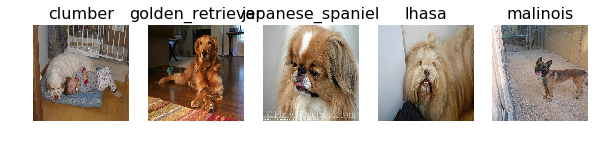

In [191]:
plot_random(test_predictions, test_gen.filenames, 5)

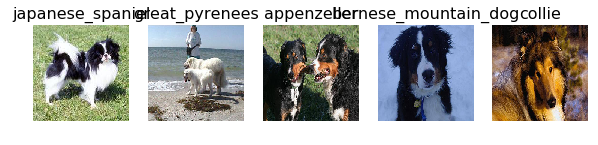

In [192]:
plot_random(test_predictions, test_gen.filenames, 5)

#### Submission

Your submission scored 0.42441, which is an improvement of your previous score of 0.50663. Great job!

## ImageNet Ensemble

Going to attempt to train an ensemble using all the trained ImageNet models.

In [4]:
import pickle

from keras.models import load_model
from keras.applications import vgg16, vgg19, resnet50, inception_v3, xception

from keras.layers import Lambda
from keras import backend as K
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy
import tensorflow as tf
from sklearn.metrics import log_loss
from tqdm import tqdm

import numpy as np

tqdm.monitor_interval = 0

Firstly, going to collect training and dev predictions for each model.

In [5]:
def get_preds(model, img_gen, max_iterations):
    count = 0
    
    preds = []
    labels = []
    
    for x_train, y_train in tqdm(img_gen, total=max_iterations):
        if count >= max_iterations:
            break
        
        preds.append(model.predict(x_train))
        labels.append(y_train)
        
        count += 1
        
    return np.concatenate(preds, axis=0), np.concatenate(labels, axis=0)

In [6]:
DEFAULT_TARGET_SIZE = (224, 224)
MODEL_DATA = [
    dict(
        model_path='vgg_aug_v1.h5',
        preprocessing_function=vgg16.preprocess_input,
        target_size=DEFAULT_TARGET_SIZE),
    dict(
        model_path='vgg19_v1.h5',
        preprocessing_function=vgg19.preprocess_input,
        target_size=DEFAULT_TARGET_SIZE),
    dict(
        model_path='resnet_v1_aug.h5',
        preprocessing_function=resnet50.preprocess_input,
        target_size=DEFAULT_TARGET_SIZE),
    dict(
        model_path='inceptionv3_v1.h5',
        preprocessing_function=inception_v3.preprocess_input,
        target_size=DEFAULT_TARGET_SIZE),
    dict(
        model_path='xception_conv_unfreeze_v2_229x299',
        preprocessing_function=xception.preprocess_input,
        target_size=(299, 299)
    )
]

TRAIN_PREDS = {}
DEV_PREDS = {}

In [11]:
for model_data in MODEL_DATA:
    model = load_model('./models/{0}'.format(model_data['model_path']))
    datagen = ImageDataGenerator(
        preprocessing_function=model_data['preprocessing_function'])
    
    train_gen = datagen.flow_from_directory(
    './data/prepared/train',
        target_size=model_data['target_size'], shuffle=True, seed=42)
    
    max_iterations = train_gen.n // train_gen.batch_size + 1
    train_preds, labels = get_preds(model, train_gen, max_iterations)

    dev_gen = datagen.flow_from_directory(
        './data/prepared/dev',
        target_size=model_data['target_size'], shuffle=True, seed=42)
    max_iterations = dev_gen.n // dev_gen.batch_size + 1

    dev_preds, dev_labels = get_preds(model, dev_gen, max_iterations)
    
    TRAIN_PREDS[model_data['model_path']] = train_preds
    DEV_PREDS[model_data['model_path']] = dev_preds

Found 9162 images belonging to 120 classes.


  0%|          | 0/34 [00:00<?, ?it/s]

Found 1060 images belonging to 120 classes.


100%|██████████| 34/34 [00:24<00:00,  1.37it/s]


Found 9162 images belonging to 120 classes.


  0%|          | 0/34 [00:00<?, ?it/s]

Found 1060 images belonging to 120 classes.


100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


Found 9162 images belonging to 120 classes.


  0%|          | 0/34 [00:00<?, ?it/s]

Found 1060 images belonging to 120 classes.


100%|██████████| 34/34 [00:16<00:00,  2.01it/s]
/home/ubuntu/anaconda2/envs/dog-breed/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Found 9162 images belonging to 120 classes.


  0%|          | 0/34 [00:00<?, ?it/s]

Found 1060 images belonging to 120 classes.


100%|██████████| 34/34 [00:14<00:00,  2.36it/s]


Found 9162 images belonging to 120 classes.


  0%|          | 0/34 [00:00<?, ?it/s]

Found 1060 images belonging to 120 classes.


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


In [22]:
pickle.dump(TRAIN_PREDS, open('./pickle/TRAIN_PREDS', 'wb'))
pickle.dump(DEV_PREDS, open('./pickle/DEV_PREDS', 'wb'))

In [ ]:
pickle.dump(labels, open('./pickle/pred_labels', 'wb'))
pickle.dump(dev_labels, open('./pickle/pred_dev_labels', 'wb'))

In [14]:
TRAIN_PREDS = pickle.load(open('./pickle/TRAIN_PREDS', 'rb'))
DEV_PREDS = pickle.load(open('./pickle/DEV_PREDS', 'rb'))

In [15]:
labels = pickle.load(open('./pickle/pred_labels', 'rb'))
dev_labels = pickle.load(open('./pickle/pred_dev_labels', 'rb'))

In [16]:
print("Model accuracy")
print()

for m in MODEL_DATA:
    model_path = m['model_path']
    train_preds = TRAIN_PREDS[model_path]
    dev_preds = DEV_PREDS[model_path]
    print(model_path)
    print(log_loss(np.argmax(labels, axis=1), train_preds))
    print(log_loss(np.argmax(dev_labels, axis=1), dev_preds))
    print()

Model accuracy

vgg_aug_v1.h5
0.0423600556024
1.51283139823

vgg19_v1.h5
0.170050470216
1.22677787756

resnet_v1_aug.h5
0.136609222286
0.9848901587

inceptionv3_v1.h5
0.746020674288
1.14158027618

xception_conv_unfreeze_v2_229x299
0.0886596135855
0.373329879983



Next, I'll build a simple model that takes predictions for each model and attempts to output predictions for the dog classes.

In [17]:
# First convert the list of predictions into a (None, 5, 120) array.
x_train = np.stack([TRAIN_PREDS[m['model_path']] for m in MODEL_DATA])
x_train = x_train.transpose((1, 0, 2))

In [18]:
x_train.shape

(9162, 5, 120)

In [19]:
x_dev = np.stack([DEV_PREDS[m['model_path']] for m in MODEL_DATA])
x_dev = x_dev.transpose((1, 0, 2))

In [20]:
x_dev.shape

(1060, 5, 120)

Now I'll build a simple FC model that takes the 5 model predictions as input, flattens them, then outputs 120 class predictions.

In [21]:
inp = Input(shape=(5, 120))
x = Flatten()(inp)
x = Dropout(0.75)(x)
output = Dense(120, activation='softmax')(x)

model = Model(inputs=inp, outputs=output)
model.compile(
    optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(
    x_train, labels, epochs=100,
    validation_data=(x_dev, dev_labels),
    callbacks=[
        ReduceLROnPlateau(patience=3, verbose=1),
        EarlyStopping(patience=10)])

Train on 9162 samples, validate on 1060 samples
Epoch 1/100
9162/9162 [==============================] - 2s 250us/step - loss: 4.5039 - acc: 0.2733 - val_loss: 4.2705 - val_acc: 0.7613
Epoch 2/100
9162/9162 [==============================] - 1s 123us/step - loss: 3.8798 - acc: 0.6518 - val_loss: 3.7628 - val_acc: 0.7981
Epoch 3/100
9162/9162 [==============================] - 1s 122us/step - loss: 3.3585 - acc: 0.7127 - val_loss: 3.3106 - val_acc: 0.8057
Epoch 4/100
9162/9162 [==============================] - 1s 120us/step - loss: 2.9291 - acc: 0.7317 - val_loss: 2.9156 - val_acc: 0.8094
Epoch 5/100
9162/9162 [==============================] - 1s 123us/step - loss: 2.5848 - acc: 0.7434 - val_loss: 2.5760 - val_acc: 0.8132
Epoch 6/100
9162/9162 [==============================] - 1s 120us/step - loss: 2.3494 - acc: 0.7396 - val_loss: 2.2903 - val_acc: 0.8132
Epoch 7/100
9162/9162 [==============================] - 1s 125us/step - loss: 2.1809 - acc: 0.7427 - val_loss: 2.0482 - val_acc: 

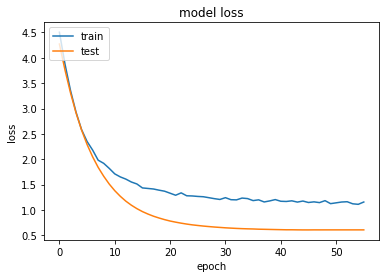

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
model.save('./models/imagenet_ensemble.h5')

Doesn't appear that this will beat my current high score. Damn! Will submit it anyway tho.

In [8]:
TEST_PREDS = {}

for model_data in MODEL_DATA:
    model = load_model('./models/{0}'.format(model_data['model_path']))
    datagen = ImageDataGenerator(
        preprocessing_function=model_data['preprocessing_function'])
    
    test_gen = datagen.flow_from_directory(
    './data/test/', target_size=model_data['target_size'], shuffle=True, seed=42)
    
    max_iterations = test_gen.n // test_gen.batch_size + 1
    preds, _ = get_preds(model, test_gen, max_iterations)
    
    TEST_PREDS[model_data['model_path']] = preds

Found 10357 images belonging to 1 classes.


100%|██████████| 324/324 [03:59<00:00,  1.35it/s]


Found 10357 images belonging to 1 classes.


100%|██████████| 324/324 [04:18<00:00,  1.25it/s]


Found 10357 images belonging to 1 classes.


100%|██████████| 324/324 [02:44<00:00,  1.97it/s]
/home/ubuntu/anaconda2/envs/dog-breed/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Found 10357 images belonging to 1 classes.


100%|██████████| 324/324 [02:20<00:00,  2.31it/s]


Found 10357 images belonging to 1 classes.


100%|██████████| 324/324 [04:51<00:00,  1.11it/s]


In [11]:
# First convert the list of predictions into a (None, 5, 120) array.
x_test = np.stack([TEST_PREDS[m['model_path']] for m in MODEL_DATA])
x_test = x_test.transpose((1, 0, 2))

In [25]:
tic = time.time()
test_predictions = model.predict(x_test)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 0.94 seconds


In [33]:
submit_predictions(test_predictions, './submissions/imagenet_ensemble.csv')